In [170]:
import numpy as np
import torch
import torch.nn as nn
import time 
import logging
import torch.optim as optim
import os
from scipy.stats import multivariate_normal as normal
import torch.nn.functional as F
from torch.nn import Parameter
import matplotlib.pyplot as plt
from torch import distributions
from sklearn import cluster, datasets, mixture

In [171]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

data_type=torch.float32
MOMENTUM = 0.99
EPSILON = 1e-6

Using cpu device


In [172]:
torch.linspace(1,2,steps=2)*torch.linspace(1,2,steps=2)

tensor([1., 4.])

In [173]:
class Config(object):
    n_layer = 4
    batch_size = 100

    dim=2; 
  #  Ntime=20; 
 #   delta=1/Ntime
  #  sqrt_deltaT=np.sqrt(1.0/Ntime); 
    gamma=2.0
    kvec2=torch.linspace(1,dim,steps=dim)*torch.linspace(1,dim,steps=dim)

    logging_frequency = 100
    verbose = True
    
    num_hiddens = [dim,256,256,dim] ## 256 ,256
    n_layers=6; n_layer_half=3; 
    
def get_config(name):
    try:
        return globals()[name]
    except KeyError:
        raise KeyError("config not defined.")

In [174]:
cfg=get_config('Config')

In [175]:
nn.Tanh

torch.nn.modules.activation.Tanh

## Basic blocks

In [176]:
"""
This function defines one block for the nn (Only one dense linear connected layer)
"""
class Dense(nn.Module): 
    def __init__(self,cin, cout, batch_norm=False, activate=False): 
        super(Dense,self).__init__()
        self.cin=cin; 
        self.cout=cout; 
        self.activate=activate; 
        self.relu=nn.LeakyReLU()
        self.linear=nn.Linear(self.cin,self.cout) #The linear layer
        #BatchNorm1d: it requires the input to be a correct size
        self.tanh=nn.Tanh()
        if batch_norm: 
            self.bn=nn.BatchNorm1d(cout,eps=EPSILON,momentum=MOMENTUM)
        else: 
            self.bn=None
      #  nn.init.normal_(self.linear.weight,std=5.0/np.sqrt(cin+cout))
        # This is the He initialization
        
    def forward(self,x): 
        x=self.linear(x)
        if self.bn is not None:
            x=self.bn(x)
        if self.activate:
            x=self.tanh(x) #x=self.relu(x)
        return x 
    
"""
Each DenseFC defined below will either be a scaling / translational 
part of the coupling block. 
"""
class DenseFC(nn.Module):
    def __init__(self, config):
        super(DenseFC,self).__init__()
        self.config=config
        
        self.bn=nn.BatchNorm1d(config.num_hiddens[0],eps=EPSILON,momentum=MOMENTUM)
        # range(1,5): 1,2,3,4
        self.layers=[Dense(config.num_hiddens[i-1],config.num_hiddens[i]) for i in range(1, len(config.num_hiddens)-1)]
        self.layers+=[Dense(config.num_hiddens[-2], config.num_hiddens[-1],activate=False)]
        self.layers=nn.Sequential(*self.layers)
        
    
    def forward(self,x):
        z=x
        x=self.bn(x)
        x=self.layers(x)
        return x 
    
class DenseFC_s(nn.Module):
    def __init__(self, config):
        super(DenseFC_s,self).__init__()
        self.config=config
        
        self.bn=nn.BatchNorm1d(config.num_hiddens[0],eps=EPSILON,momentum=MOMENTUM)
        # range(1,5): 1,2,3,4
        self.layers=[Dense(config.num_hiddens[i-1],config.num_hiddens[i]) for i in range(1, len(config.num_hiddens)-1)]
        self.layers+=[Dense(config.num_hiddens[-2], config.num_hiddens[-1],activate=False)]
        self.layers=nn.Sequential(*self.layers)
    
    def forward(self,x):
        z=x
        x=self.bn(z)
        x=self.layers(x)
        return x 

In [177]:
class CouplingLayer(nn.Module):
    def __init__(self,config, mask):
        super(CouplingLayer,self).__init__()
        
        self.cfg=config
        self.input_dim=self.cfg.dim
        self.output_dim=self.cfg.dim
        
        self.s=DenseFC_s(self.cfg) # The reference code uses tanh even for the final output for s
        self.t=DenseFC(self.cfg)
        
        self.mask=mask ## Should be defined in the cfg class
        
    def forward(self,y):## conventionally defined as g 
        log_det_jacobian,x=y.new_zeros(y.shape[0]), y; 
        
        x_m=x*self.mask # cover the second half
        s_out=self.s(x_m)*(1-self.mask)
        t_out=self.t(x_m)*(1-self.mask)
        
        ytemp=x_m +(1-self.mask)*(x*torch.exp(s_out)+t_out)
        
        log_det_jacobian=s_out.sum(dim=1) ## There is no problem with that, it's only the log_det_jacobian
        return ytemp, log_det_jacobian
    
    def backward(self,y):  ## conventionally defined as f 
        # log_det_jacobian,x=y.new_zeros(y.shape[0]),y
        
        x=y
        y_m=x*self.mask
        s_out=self.s(y_m)*(1-self.mask)
        t_out=self.t(y_m)*(1-self.mask)
        
        x=y_m+(1-self.mask)*(y-t_out)*torch.exp(-s_out) #putting them together 
       # log_det_jacobian=-s_out.sum(dim=1)
        return x #, log_det_jacobian

    ### If we are doing the forward maps, then the structure will be somewhat different. 
    
class RealNVP(nn.Module):
    def __init__(self,config,mask):
        super().__init__()
        self.cfg=config
        self.gamma=self.cfg.gamma
        
        self.modules=[];
        self.modules.append(CouplingLayer(self.cfg,mask))
        for _ in range(self.cfg.n_layers-1):
            mask=1.0-mask; 
            self.modules.append(CouplingLayer(self.cfg,mask))
        self.moduleList=nn.ModuleList(self.modules)
        
    def g(self,x):
        ldj_sum=0.0
        z=x
        for module in self.moduleList:
            z,ldj=module.forward(z)   
            ldj_sum+=ldj
        return z, ldj_sum
    
    def f(self,z):
        #ldj_sum=0.0
        x=z
        for module in reversed(self.moduleList):
            x=module.backward(x)
        return x
    
   # def log_prob(self,x, prior):
   #     z, logp= self.g(x)
#    res=prior.log_prob(z) + logp
    #    return res
    
    def g_BatchSample(self,batchsize,prior):
        z=prior.sample((batchsize,))
        x=self.g(z)
        return x
    
    def target_KL(self,z): 
        #sums=0.0;
        x,logp=self.g(z)
    
        x2=x*x; 
        norm_2=torch.sum(x2,dim=1).reshape(self.cfg.batch_size,1);
        
        ### This two are not different by that much
        sums= torch.sum(self.gamma*(1.0/norm_2*x2*self.cfg.kvec2) +x2,dim=1) - logp
        return sums
        #self.gamma*(1.0/norm_2*x2*self.cfg.kvec2) +

In [178]:
mask_temp=torch.tensor([0.0,1.0],requires_grad=False)
rvp1=RealNVP(cfg,mask_temp)
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
optimizer=torch.optim.Adam(rvp1.parameters(),lr=5e-5) 
### The learning rate is important, deeper nn structure may require much smaller learning rate. 
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2500], gamma=0.1) 

In [179]:
for t in range(5001):
    x_init = torch.randn(100,2)  #datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    loss = rvp1.target_KL(x_init).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    scheduler.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 8.104
iter 500: loss = 5.512
iter 1000: loss = 5.906
iter 1500: loss = 5.254
iter 2000: loss = 5.394
iter 2500: loss = 5.576
iter 3000: loss = 5.444
iter 3500: loss = 5.562
iter 4000: loss = 5.508
iter 4500: loss = 5.424
iter 5000: loss = 5.564


# Sampling from the 2D Bingham disribution.

The Bingham distribution is a multi-model distribution on the surface of a sphere. 
$$ \frac{1}{z_k}exp(-\gamma (x_1^2 + 4 x_2^2+ ...+ k^2x_k^2) )  d \nu$$
where $d\nu$ is the uniform distriution on the spherical surface. 

We study its ambient distriubtion:
$$\frac{1}{Z_k}exp( - \frac{\gamma}{|x|^2} (x^2_1+ 4x_2^2+ ...+ k^2x_k^2) ) \mathcal{G_2}$$
where $\mathcal{G_2}= \exp(-(x_1^2+...+x_k^2))$ (the unnormalized multivariate Gaussian)

The benefit is that now the samples all live in $\mathbb{R}^k$. After we obtain the transported samples, we simply project them to the spherical surface. 

# Original Guassian ditribution, 2D

In [203]:
sample_shape=1000
xin = torch.randn(sample_shape,2)
res1,res2=rvp1.g(xin)

Text(0.5, 1.0, '$X = g(z)$, $\\gamma=1$, Orignal Guassian ditribution')

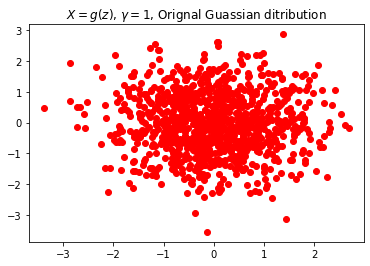

In [204]:
plt.scatter(xin[:,  0].detach().numpy(), xin[:,  1].detach().numpy(), c='r')
plt.title(r'$X = g(z)$, $\gamma=1$, Orignal Guassian ditribution')

## Transported
Here are samples after transportation, notice that the samples are slightly clusterd into two segments.

Text(0.5, 1.0, '$X = g(z)$, $\\gamma=1$, Transported Guassian')

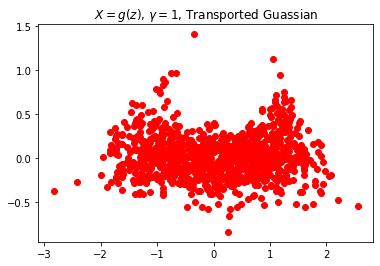

In [205]:
plt.scatter(res1[:,  0].detach().numpy(), res1[:,  1].detach().numpy(), c='r')
plt.title(r'$X = g(z)$, $\gamma=1$, Transported Guassian')

# Projected

After projection, we see that the orignal samples are now transported to the different modes on the circle.

In [206]:
res1_norm=torch.sqrt(torch.sum(res1*res1,dim=1))
res1_norm=res1_norm.reshape(sample_shape,1)

In [207]:
res1=1.0/res1_norm*res1

Text(0.5, 1.0, '$X = g(z)$, $\\gamma=1$, Projected ')

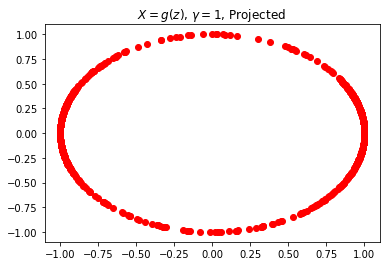

In [208]:
plt.scatter(res1[:,  0].detach().numpy(), res1[:,  1].detach().numpy(), c='r')
plt.title(r'$X = g(z)$, $\gamma=1$, Projected ')